# Imports

In [2]:
%reload_ext autoreload

In [3]:
%autoreload
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time 
import seaborn as sns
from utils import *
import torch
import umap.umap_ as umap
from scipy.stats import poisson

# Model
from model_ensamble_bayes import HMM_bayes
from hmmlearn import hmm

# Simulate data


In [3]:
num_neurons = 25
num_states_1 = 2
num_states_2 = 2
frec_1 = 5
frec_2 = 5
T_max = 5000

X_3_states, y_state_3 = simulate_state(num_neurons, num_states_1, frec_1, T_max)
X_4_states, y_state_4 = simulate_state(num_neurons, num_states_2, frec_2, T_max)

X_state_ensamble = pd.concat([X_3_states, X_4_states], axis = 1)
y_ensamble = np.concatenate((y_state_3.reshape(-1, 1), y_state_4.reshape(-1, 1)), axis = 1)


# Fit model


## Sklearn model

In [4]:
n_states = 12
X = X_state_ensamble
n_retraining = 3


model_list = list()
score_list = list()
start_time = time.time()

for idx in range(n_retraining):
    model = hmm.PoissonHMM(n_components = n_states, verbose=True, random_state = idx, n_iter=10, tol = 500)
    try:
        model.fit(X)
    except:
        score_list.append(-np.inf)
        continue
    
    model_list.append(model)
    score_list.append(model.score(X))
    print(f'Converged: {model.monitor_.converged}\t\t'
              f'Score: {score_list[-1]}')
print("--- %s seconds ---" % (time.time() - start_time))

         1 -1365089.90563717             +nan
         2 -306571.22982028 +1058518.67581689
         3 -225278.11702251  +81293.11279777
         4 -223318.83619970   +1959.28082281
         5 -223317.81176772      +1.02443198


Converged: True		Score: -223317.67315987698


         1 -1364491.17303395             +nan
         2 -361044.81265733 +1003446.36037662
         3 -247444.08818150 +113600.72447583
         4 -215025.76254863  +32418.32563287
         5 -203498.81340525  +11526.94914338
         6 -203498.81340059      +0.00000466


Converged: True		Score: -203498.8134005904


         1 -1359824.87738238             +nan
         2 -383346.79488653 +976478.08249586
         3 -336591.43990851  +46755.35497801
         4 -291958.73605540  +44632.70385311
         5 -283873.48263400   +8085.25342140
         6 -283871.43728668      +2.04534733


Converged: True		Score: -283863.9180768721
--- 5.995509624481201 seconds ---


In [ ]:
model_sk = model_list[np.argmax(score_list)]
states_head_sk = model_sk.predict(X)

In [34]:
file_path = f'models/{path}/model.pkl'
os.makedirs(os.path.dirname(file_path), exist_ok=True)
joblib.dump(model, file_path)

['models/sim_ensemble_d5000_nh200_ns100_b0.005_p2_t5_s5_id92997_ms20/model.pkl']

- `d`: Data length
- `nh`: Number of head neurons
- `ns`: Number of state neurons
- `b`: Back firing
- `p`: Peak firing
- `t`: Tuning width
- `s`: Number of states used when simulating state neurons
- `ms`: Model states (Number of states used when fitting the HMM)


In [1]:

transition_matrix = model.transmat_.copy()
np.fill_diagonal(transition_matrix, 0)

# Step 1: Compute pairwise distances based on the transition probabilities
# Replace 'transition_matrix' with your actual transition probability matrix
# You may want to convert the transition matrix to distance by taking the inverse
distance_matrix = 1 - transition_matrix

# Step 2: Apply UMAP to reduce dimensionality
# You can adjust the number of components and other parameters as needed
n_components = 10  # Number of dimensions in the UMAP projection
umap_model = umap.UMAP(n_neighbors=5, n_components=n_components, min_dist=0.1)
umap_result = umap_model.fit_transform(distance_matrix)

# Step 3: Visualize the UMAP results
plt.figure(figsize=(8, 6))
plt.scatter(umap_result[:, 0], umap_result[:, 1], c=range(len(umap_result)), cmap='viridis', s=20)
plt.colorbar(label='State Index')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.title('UMAP Visualization of State Space')
plt.show()


NameError: name 'model' is not defined

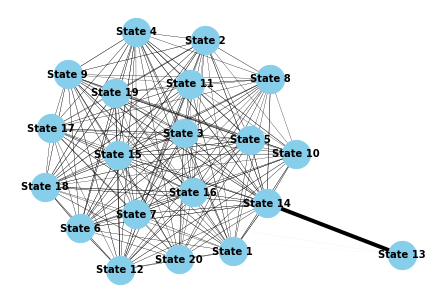

In [35]:
transition_matrix = model.transmat_.copy()
np.fill_diagonal(transition_matrix, 0)

plot_transition_graph(transition_matrix, path)

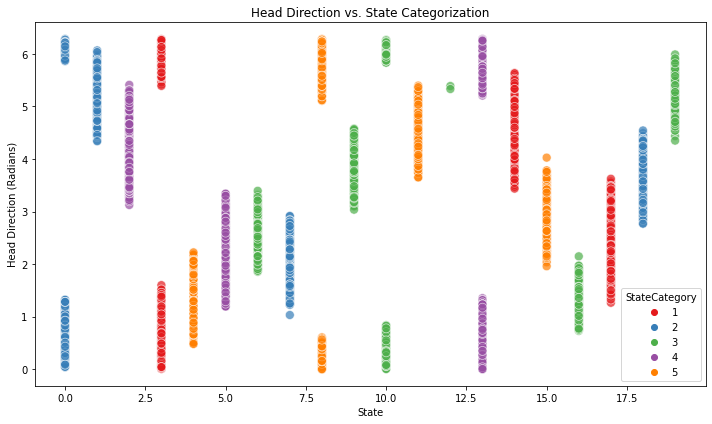

In [36]:
scatterplot_with_color(y_head, states_head, state_labels=y_state, path=path)

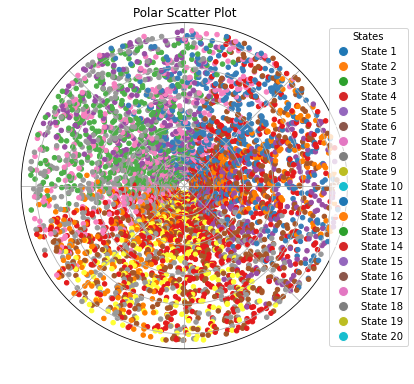

In [37]:
plot_polar_scatter(y_head, states_head, path)

# Test

In [20]:
import torch
import torch.distributions as dist
import torch.optim as optim
import itertools
from functools import reduce
from torch import nn

class HMM_bayes(torch.nn.Module):
    """
    Hidden Markov Model with discrete observations.
    """
    def __init__(self, n_state_list, m_dimensions, max_iterations = 100, tolerance = 0.1, verbose = True, lambda_max_iter = 10, lambda_tol = 10, lambda_learning_rate = 0.1, use_combine = True, early_stop_patience = 3):
        super(HMM_bayes, self).__init__()
        self.n_state_list = n_state_list  # number of states
        self.tot_dim = reduce(lambda x, y : x * y, self.n_state_list) # Product of all states
        
        self.T_max = None # Max time step
        self.m_dimensions = m_dimensions 
        self.num_laten_variables = len(self.n_state_list)
        self.dim_to_reduce = tuple(range(1, self.num_laten_variables+1))
        
        self.lambda_max_iter = lambda_max_iter
        self.lambda_tol = lambda_tol
        self.lambda_learning_rate = lambda_learning_rate
        self.early_stop_patience = early_stop_patience
        
        self.max_iterations = max_iterations
        self.tolerance = tolerance
        
        self.verbose = verbose
        
        # A
        self.transition_matrix_list = []
        self.log_transition_matrix_list = []
        for N in n_state_list:
            transition_matrix = nn.functional.softmax(torch.randn(N,N), dim = 0)
            self.transition_matrix_list.append(transition_matrix)
            self.log_transition_matrix_list.append(transition_matrix.log())
        self.transition_matrix_combo = None
        
        # b(x_t)
        ## Only lambdas are parameters that needs to be optimized
        self.unnormalized_lambda_list = nn.ParameterList([
            nn.Parameter(torch.randn(N, m_dimensions))
            for N in n_state_list
        ])
        self.lambda_list = [torch.exp(lambdas) for lambdas in self.unnormalized_lambda_list]
        self.base_rate = nn.Parameter(torch.randn(1))
        
        self.log_emission_matrix = None
        self.emission_matrix = None

        # If using the algorithm which fits the combined lambdas
        self.use_combine = use_combine
        if use_combine:
            self.lambda_combined = self.combine_lambdas()
        

        # pi
        self.state_priors_list = []
        self.log_state_priors_list = []
        for N in n_state_list:
            state_priors = torch.nn.functional.log_softmax(torch.rand(N)*10, dim = 0)
            self.state_priors_list.append(state_priors)
            self.log_state_priors_list.append(state_priors.exp())
        self.log_state_priors_combo = None

        # use the GPU
        self.is_cuda = torch.cuda.is_available()
        if self.is_cuda:
            self.cuda()

    def emission_model(self, x, log = True):
        """
        x: LongTensor of shape (T_max, m_dimensions)

        Get observation log probabilities
        Returns:
            log_probabilities: FloatTensor of shape (T_max, self.n_states_list)
        """
        # Compute Poisson log probabilities for each lambda in parallel
        if self.use_combine:
            combined_lambdas = self.lambda_combined
        else:
            combined_lambdas = self.combine_lambdas()
        poisson_dist = dist.Poisson(combined_lambdas)
        dim_probs = (x.shape[0],) + tuple(self.n_state_list)
        log_probabilities = torch.zeros(dim_probs).float()
        for t in range(x.shape[0]):
            # The last dimension specify the dimension of the data.
            # We sum this dimension togheter.
            log_probabilities[t,:] = poisson_dist.log_prob(x[t,:]).sum(dim=-1)
        if log:
            return log_probabilities
        
        return log_probabilities.exp()
        
    
    def alpha_calc(self):
        alpha_list = []
        for i in range(len(self.emission_matrix_list)):
            emission_matrix = self.emission_matrix_list[i]
            alpha = torch.zeros(self.T_max, self.n_state_list[i]).float()
            if self.is_cuda:
                alpha = alpha.cuda()
            
            alpha[0,:] = emission_matrix[0,:] + self.log_state_priors
            
            for t in range(1, self.T_max):
                alpha[t, :] = emission_matrix[t, :] * torch.matmul(self.transition_matrix, alpha[t-1, :])
            
            return alpha_list
    
    def beta_calc(self):
        beta = torch.ones(self.T_max, self.n_states).float()
        if self.is_cuda:
            beta = beta.cuda()
        
        for t in range(self.T_max - 2, -1, -1):
            beta_t_s = torch.zeros(self.n_states).float()
            for s in range(self.n_states):
                for k in range(self.n_states):
                    beta_t_s[s] += beta[t+1,k]*self.transition_matrix[s,k]*self.emission_matrix[t+1,k]
            beta[t,:] = beta_t_s
        
        return beta
                    
    def log_alpha_calc(self):
        """
        self.log_emission_matrix: longTensor of shape (T_max, n_state_1, ..., n_state_L)
        self.log_state_priors: longTensor of shape (n_state_1, ..., n_state_L)

        Returns:
            log_alpha: floatTensor of shape (T_max, n_state_1, ..., n_state_L)
        """
        assert self.log_emission_matrix is not None, "No emission matrix"
        assert self.T_max is not None, "No maximum time"
        
        dim_alpha = (self.T_max,) + tuple(self.n_state_list)
        log_alpha = torch.zeros(dim_alpha).float()
        if self.is_cuda:
            log_alpha = log_alpha.cuda()

        log_alpha[0, :] = self.log_emission_matrix[0, :] + self.log_state_priors_combo 
        # log_alpha[1:self.T_max,:] = log_emission_matrix[1:self.T_max,:] + log_transition_matrix[0:(self.T_max-1), :]
        for t in range(1, self.T_max):
            # Creat a list of sums with log_alpha and transition_matrix_combos
            log_alpha_list = []
            for _ in range(self.tot_dim):
                log_alpha_list.append(log_alpha[t-1,:])
            log_alpha_repeat = torch.stack(log_alpha_list)
            
            log_alpha_trans_sum = self.transition_matrix_combo + log_alpha_repeat
            # Take logsumexp over all dimension except the first.
            # We now have vector with length equal to the product of all dimensions
            lats = log_alpha_trans_sum.logsumexp(dim = self.dim_to_reduce)
            # We then reshape the vector to a tensor with dimensions equal to the different number of states
            mat_prod = lats.view(tuple(self.n_state_list))
            # We then sum this tensor with the emission probabilities to 
            log_alpha[t, :] = self.log_emission_matrix[t, :] + mat_prod
        
        return log_alpha
    
    def log_beta_calc(self):
        assert self.log_emission_matrix is not None, "No emission matrix"
        
        tot_dim = reduce(lambda x, y : x * y, self.n_state_list)
        
        dim_beta = (self.T_max,) + tuple(self.n_state_list)
        log_beta = torch.zeros(dim_beta).float()
        if self.is_cuda:
            log_beta = log_beta.cuda()
    
        for t in range(self.T_max -2, -1, -1):
            log_beta_list = []
            for _ in range(tot_dim):
                log_beta_list.append(log_beta[t+1,:])
            log_beta_repeat = torch.stack(log_beta_list)
            
            log_beta_trans_sum = self.transition_matrix_combo + log_beta_repeat + self.log_emission_matrix[t+1,:]
            sum_reduced = log_beta_trans_sum.logsumexp(dim=self.dim_to_reduce)
            log_beta[t,:] = sum_reduced.view(tuple(self.n_state_list))
        
        return log_beta
        
    
    def forward(self, x):
        """
        x: IntTensor of shape (T_max, m_dimensions)

        Compute log p(x)
        """
        self.T_max = x.shape[0]
        self.log_emission_matrix = self.emission_model(x)
        log_alpha = self.log_alpha_calc()

        log_prob = log_alpha[self.T_max - 1, :].flatten().logsumexp(dim = 0)
        return log_prob
    
    def get_lambdas(self):
        return self.lambdas_list
            
    
    def fit(self, x):
        """ Estimates optimal transition matrix and lambdas given the data x.

        Args:
            x (torch): T_max x m_dimensions
            log_alpha (torch) : T_max x N
            log_beta (torch) : T_max x N
        """
        
        self.T_max = x.shape[0]
        prev_log_likelihood = float('-inf')
        log_x = torch.log(x + 1e-16)
        
        best_log_likelihood = float('-inf')
        best_log_state_priors_list = self.log_state_priors_list
        best_log_transition_matrix_list = self.log_transition_matrix_list
        if self.use_combine:
            best_lambda_combined = self.lambda_combined
        else: 
            best_lambda_list = self.lambda_list
        
        # Get emission matrix
        self.log_emission_matrix = self.emission_model(x)
        
        # Combine state priors and transition matrix from list of matrices to multidimensional tensor
        self.transition_matrix_combo = self.combine_transition_matrices()
        self.log_state_priors_combo = self.combine_priors()
        
        ## Calculate log_alpha
        log_alpha = self.log_alpha_calc()
        
        ## Calculate inital log_likelihood
        log_likelihood = log_alpha[self.T_max - 1, :].flatten().logsumexp(dim = 0)
        
        for iteration in range(self.max_iterations):  
            # E step
            ## Caculcate log_beta
            log_beta = self.log_beta_calc()
            
            ## Calculate log_gamma
            gamma_numerator = log_alpha + log_beta
            gamma_denominator = gamma_numerator.logsumexp(dim=self.dim_to_reduce, keepdim=True)
            
            log_gamma = gamma_numerator - gamma_denominator.expand_as(gamma_numerator)
            
            log_gamma_list = []
            log_emission_matrix_list = []
            log_alpha_list = []
            log_beta_list = []
            for i in range(self.num_laten_variables):
                dim_reduce_i = tuple(list(self.dim_to_reduce)[:i] + list(self.dim_to_reduce)[i + 1:])
                # dim_reduce_i = tuple(list(self.dim_to_reduce).remove(i+1))
                
                log_gamma_i = log_gamma.logsumexp(dim = dim_reduce_i) 
                log_gamma_list.append(log_gamma_i)
                
                log_emission_matrix_i = self.log_emission_matrix.logsumexp(dim = dim_reduce_i)
                log_emission_matrix_list.append(log_emission_matrix_i)
                
                log_alpha_i = log_alpha.logsumexp(dim = dim_reduce_i)
                log_alpha_list.append(log_alpha_i)
                
                log_beta_i = log_beta.logsumexp(dim = dim_reduce_i)
                log_beta_list.append(log_beta_i)
                
            
            
            ## Calculate log_xi
            log_xi_list = []
            for i in range(self.num_laten_variables):
                xi_numerator_i = (log_alpha_list[i][:-1, :, None] + self.log_transition_matrix_list[i][None, :, :] + log_beta_list[i][1:, None, :] + log_emission_matrix_list[i][1:, None, :])
                xi_denominator = xi_numerator_i.logsumexp(dim = (1,2), keepdim=True)
                
                log_xi_i = xi_numerator_i - xi_denominator
                log_xi_list.append(log_xi_i)
                
            # M step
            ## Update pi
            for i in range(len(self.n_state_list)):
                log_gamma_i = log_gamma_list[i]
                self.log_state_priors_list[i] = log_gamma_i[0,] - log_gamma_i.logsumexp(dim = 0)
            
            ## Updaten transition matrix
            for i in range(self.num_laten_variables):
                trans_numerator_i = log_xi_list[i].logsumexp(dim = 0)
                trans_denominator_i = log_gamma_list[i][0:(self.T_max-1),:].logsumexp(dim = 0)
                
                self.log_transition_matrix_list[i] =  trans_numerator_i - trans_denominator_i.view(-1, 1)
            
            
            ## Update lambda
            ### Optimizing every combination of lambdas.
            if self.use_combine:
                # Move T_max from first dimension to last dimension: (T_max, n_1, ..., n_L) -> (n_1, ..., n_L, T_max)
                new_dim = tuple(range(1, self.num_laten_variables + 1)) + (0,) 
                log_gamma_perm = torch.permute(log_gamma, new_dim)
                
                # log_gamma_perm is of form (n_1, ..., n_L, T_max), log_x of (T_max)
                # So product is of form (n_1,..., n_L)
                lambda_numerator = self.log_domain_matmul(log_gamma_perm, log_x, dim_1 = False)
                lambda_denominator_instance = log_gamma_perm.logsumexp(dim = -1)
                lambda_denominator = torch.stack([lambda_denominator_instance] * self.m_dimensions, dim=-1)
                self.lambda_combined = torch.exp(lambda_numerator - lambda_denominator)
            
            ### Optimizing indvidual lambdas
            else:
                # Does not work yet
                lambda_loss = -log_likelihood  # Need (-) because optim minimizes loss
                optimizer = optim.Adam(self.parameters(), lr = self.lambda_learning_rate)
                for epoch in range(self.lambda_max_iter):
                    # Optimize
                    optimizer.zero_grad()
                    lambda_loss.backward(retain_graph=True)
                    
                    optimizer.step()
                    
                    # Calculate new loss
                    new_lambda_loss = -self.forward(x) # Need (-) because optim minimizes loss
                    lambda_likelihood_change = -(new_lambda_loss - lambda_loss)
                    
                    if self.verbose:
                        if lambda_likelihood_change > 0:
                            print(f"Lambda fiting: {epoch + 1} {-new_lambda_loss:.4f}  +{lambda_likelihood_change}")
                        else:
                            print(f"Lambda fiting: {epoch + 1} {-new_lambda_loss:.4f}  {lambda_likelihood_change}")
                    
                    if lambda_likelihood_change > 0 and lambda_likelihood_change < self.lambda_tol:
                        break
                    lambda_loss = new_lambda_loss
            
            # Do necessary calculations for log_likelihood. These will also be used in the next iteration 
            # Get emission matrix
            self.log_emission_matrix = self.emission_model(x)
                   
            # Combine state priors and transition matrix from list of matrices to multidimensional tensor
            self.transition_matrix_combo = self.combine_transition_matrices()
            self.log_state_priors_combo = self.combine_priors()
                
            ## Calculate log_alpha
            log_alpha = self.log_alpha_calc()
            
            # Chack for tolerance
            log_likelihood =  log_alpha[self.T_max - 1, :].flatten().logsumexp(dim = 0)
            log_likelihood_change = log_likelihood - prev_log_likelihood
            prev_log_likelihood = log_likelihood 
            if self.verbose:
                if log_likelihood_change > 0:
                    print(f"{iteration + 1} {log_likelihood:.4f}  +{log_likelihood_change}")
                else:
                    print(f"{iteration + 1} {log_likelihood:.4f}  {log_likelihood_change}")
            
            if log_likelihood > best_log_likelihood:
                best_log_likelihood = log_likelihood
                best_log_state_priors_list = self.log_state_priors_list
                best_log_transition_matrix_list = self.log_transition_matrix_list 
                
                if self.use_combine:
                    best_lambda_combined = self.lambda_combined
                else:
                    best_lambda_list = self.lambda_list
            
            # Check for max iteration
            if self.verbose and iteration == self.max_iterations -1:
                print("Max iteration reached.")
            
            # Chack for tolerance
            if log_likelihood_change < self.tolerance and log_likelihood_change > 0:
                if self.verbose:
                    print("Converged (change in log likelihood within tolerance)")
                break
            
        
        # After iteration, use best paramters
        self.log_state_priors_list = best_log_state_priors_list
        self.log_transition_matrix_list = best_log_transition_matrix_list 
        if self.use_combine:
            self.lambda_combined = best_lambda_combined
        else: 
            self.lambda_list = best_lambda_list
        
        # Separate the lambdas from self.lambda_combined, defining new lambda in self.lambda_list
        self.separate_lambdas_optim()
        self.lambda_combined = self.combine_lambdas(normalized=False)
    
    def predict(self, x):
        """
        x: IntTensor of shape (T_max, m_dimensions)

        Find argmax_z log p(z|x)
        """
        if self.is_cuda:
            x = x.cuda()

        T_max = x.shape[0]
        
        self.log_state_priors_combo = self.combine_priors()
        
        dim_delta = (self.T_max,) + tuple(self.n_state_list)
        log_delta = torch.zeros(dim_delta).float()
        psi = {}
        if self.is_cuda:
            log_delta = log_delta.cuda()
            
        self.log_emission_matrix = self.emission_model(x)
        
        log_delta[0,] = self.log_emission_matrix[0,] + self.log_state_priors_combo
        for t in range(1,self.T_max):
            log_delta_list = []
            for _ in range(self.tot_dim):
                log_delta_list.append(log_delta[t-1,])
            log_delta_repeat = torch.stack(log_delta_list)
            delta_trans_sum = self.transition_matrix_combo + log_delta_repeat

            max_val_list = []
            argmax_val_list = []
            for i in range(self.tot_dim):
                max_val_i = torch.max(delta_trans_sum[i,])
                max_val_list.append(max_val_i)

                argmax_index_i = torch.argmax(delta_trans_sum[i,])
                argmax_val_i = unravel_index(argmax_index_i, tuple(self.n_state_list))
                argmax_val_list.append(argmax_val_i)
            
            max_val_tensor = torch.tensor(max_val_list).view(tuple(self.n_state_list))
            
            log_delta[t,] = self.log_emission_matrix[t,] + max_val_tensor
            psi[t] = argmax_val_list
        
        z_dim = (self.T_max, self.num_laten_variables)
        z_star = torch.zeros(z_dim).long()
        delta_argmax = torch.argmax(log_delta[T_max -1,])
        
        z_star[self.T_max -1,] = torch.tensor(unravel_index(delta_argmax, tuple(self.n_state_list)))
        for t in range(T_max - 2, -1, -1):
            max_unravel_index = z_star[t+1,]
            max_ravel_index = ravel_index(max_unravel_index, tuple(self.n_state_list))
            
            argmax_index_list = psi[t+1]
            
            z_star[t,] = torch.tensor(argmax_index_list[max_ravel_index])
        
        return z_star

    def get_transition_matrix(self):
        return torch.exp(self.log_transition_matrix)
    
    def combine_lambdas(self, normalized = True):
        """Combines every possible combination of lambdas and adds them togheter

        Returns:
            lambda_combined: FloatTensor of shape (self.n_state_list, self.m_dimensions)
        """
        dim_tuple = (self.m_dimensions,)  + tuple(self.n_state_list)
        lambda_combined = torch.zeros(dim_tuple, dtype=torch.float)
        
        if normalized:
            lambda_list = self.lambda_list
        else:
            lambda_list = [torch.exp(lambdas) for lambdas in self.unnormalized_lambda_list]

        # Data on the on the form x = (x_1,...,x_m), where each x_i has T_max number of time steps
        # We iterate over each dimension and caclulate the combined lambdas
        # for each dimension
        combined_list = []
        for m in range(self.m_dimensions):
            # A list of all lambdas for that dimension in every statespace
            sets = [torch.select(element, -1, m) for element in lambda_list]

            # Find every possible combination of lambdas
            combinations = []
            # Each combination is sumed togheter and stacked into a tensor
            for combo in itertools.product(*sets):
                combinations.append(torch.stack(list(combo)).sum())
            combined_set = torch.stack(combinations).view(tuple(self.n_state_list))
            combined_list.append(combined_set)
            
            # combined_set = torch.stack([torch.sum(list(combo)) for combo in combinations])
        
        lambda_combined = torch.stack(combined_list)
        
        # Move m_dimension from front to back: (m_dimensions,...) -> (..., m_dimensions)
        new_dim = tuple(range(1, self.num_laten_variables + 1)) + (0,) 
        
        lambda_combined = torch.permute(lambda_combined, new_dim)
        
        # Add base rate
        lambda_combined = lambda_combined + self.base_rate
        
        return lambda_combined

    def simple_separate_lambdas(self):
        reverse_dim = (self.num_laten_variables,) + tuple(range(self.num_laten_variables))
        lambda_combined_perm = torch.permute(self.lambda_combined, reverse_dim)
        
        new_lambda_list = [torch.zeros(n, self.m_dimensions).float() for n in self.n_state_list]
        for m in range(self.m_dimensions):             
            tot_lambda = lambda_combined_perm[m,:].sum().item()
            lambda_estimate = tot_lambda/(self.tot_dim*self.num_laten_variables)
            
            for i in range(self.num_laten_variables):
                new_lambda_list[i][:,m] = lambda_estimate
        
        self.lambda_list = new_lambda_list
            
            
    
    def combine_transition_matrices(self):
        tensor_list = []
        sets = []
        for trans_mat in self.log_transition_matrix_list:
            trans_mat_rows = [row for row in trans_mat]
            sets.append(trans_mat_rows)
        combinations = itertools.product(*sets)
        for combo in combinations:
            sub_combo = itertools.product(*list(combo))
            combined_set = torch.stack([torch.stack(list(c)).sum() for c in sub_combo])
            tensor_list.append(combined_set.view(tuple(self.n_state_list)))
        
        return torch.stack(tensor_list)
    
    def combine_priors(self):
        combinations = []
        for combo in itertools.product(*self.log_state_priors_list):
            combinations.append(torch.stack(list(combo)).sum())
        combined_set = torch.stack(combinations).view(tuple(self.n_state_list))
        
        return combined_set
    
    def separation_loss(self,h = 1, M=1e+10):
        combine_lambdas = self.combine_lambdas(normalized=False) + torch.exp(self.base_rate) # Combine self.lambda_list into sums of all possible combinations and add base rate
        lambda_list = [torch.exp(lambdas) for lambdas in self.unnormalized_lambda_list]
        
        loss_function = nn.MSELoss()
        loss = loss_function(combine_lambdas, self.lambda_combined)
        if self.verbose:
            print(f"Pure separation loss: {loss.item()}")

        # Add a penalty to the size of lambdas
        # for l in lambda_list:
        #     loss += h*torch.sum(torch.abs(l)) # Lasso penalty to squeez lambdas towards zero 
        
        return loss
    
    def log_domain_matmul(self, log_A, log_B, dim_1 = True, max = False):
        """
        log_A: (n_1 x ... x n_L) x t
        log_B: t x m
        output: (n_1 x ... x n_L) x m matrix

        Normally, a matrix multiplication
        computes out_{i,j} = sum_k A_{i,k} x B_{k,j}

        A log domain matrix multiplication
        computes out_{i,j} = logsumexp_k log_A_{i,k} + log_B_{k,j}
        """
        if not dim_1:
            # Transform both log_A and log_B to shape (n_1 x ... x n_L) x t x m
            m = self.tot_dim
            p = log_B.shape[1]
            
            new_dim = tuple(self.n_state_list) + tuple(log_B.shape)

            log_A = torch.stack([log_A] * p, dim=-1)
            log_B = torch.stack([log_B] * m, dim=0).view(new_dim) # !!! Should maybe use repeat her, not stack + view. Need to look into

        if max:
            print(log_A.shape)
            print(log_B.shape)
        
        elementwise_sum = log_A + log_B
        if max:
            # max over t
            out1, out2 = torch.max(elementwise_sum, dim = -2)
            return out1, out2
        
        # or sum over t
        out = torch.logsumexp(elementwise_sum, dim = -2)
        return out
    
    # def separate_lambdas_optim(self):
    #     lambda_loss = self.separation_loss()
    #     optimizer = optim.Adam(self.parameters(), lr = self.lambda_learning_rate)
    #     for epoch in range(self.lambda_max_iter):
    #         # Optimize
    #         optimizer.zero_grad()
    #         lambda_loss.backward(retain_graph=True)
            
    #         # for param in self.parameters():
    #         #     param.grad.data.clamp_(min=1e-16)
            
    #         optimizer.step()
            
    #         # Calculate new loss
    #         new_lambda_loss = self.separation_loss() 
    #         lambda_loss_change = new_lambda_loss - lambda_loss
            
    #         if self.verbose:
    #             if lambda_loss_change > 0:
    #                 print(f"Lambda separation loss: {epoch + 1} {new_lambda_loss:.4f}  +{lambda_loss_change}")
    #             else:
    #                 print(f"Lambda separation loss: {epoch + 1} {new_lambda_loss:.4f}  {lambda_loss_change}")
            
    #         if lambda_loss_change > 0 and lambda_loss_change < self.lambda_tol:
    #             break
    #         lambda_loss = new_lambda_loss
            
    def separate_lambdas_optim(self):
        # Initialize optimizer
        optimizer = optim.Adam(self.parameters(), lr = self.lambda_learning_rate)

        best_loss = float('inf')  # Track the best loss for early stopping
        early_stop_counter = 0  # Counter for early stopping

        for epoch in range(self.lambda_max_iter):
            # Optimize
            optimizer.zero_grad()
            lambda_loss = self.separation_loss()
            lambda_loss.backward(retain_graph=True)
            optimizer.step()

            # Early stopping
            if lambda_loss < best_loss:
                best_loss = lambda_loss
                early_stop_counter = 0
            else:
                early_stop_counter += 1

            if early_stop_counter >= self.early_stop_patience:
                print(f"Stopping early at epoch {epoch+1} due to no improvement in loss.")
                break

            if self.verbose:
                print(f"Lambda separation loss at epoch {epoch+1}: {lambda_loss.item()}")

        return best_loss

    
    def separate_lambdas(self):
        # NOTE: Does not work since may return negative lambda values. 
        new_dim = (self.num_laten_variables,) + tuple(range(self.num_laten_variables))
        lambda_combined_perm = torch.permute(self.lambda_combined, new_dim)
        dim_to_reduce = tuple(range(self.num_laten_variables))
        
        t = self.tot_dim
        
        for m in range(self.m_dimensions):
            lambda_combined_m = lambda_combined_perm[m]
            tot_lambda = torch.sum(lambda_combined_m)
            for i in range(len(self.n_state_list)):
                n = self.n_state_list[i]
                dim_reduce_i = tuple(list(dim_to_reduce)[:i] + list(dim_to_reduce)[i + 1:])
                lambda_combined_reduced = lambda_combined_m.sum(dim = dim_reduce_i)
                
                my = (n**2 - n)*t/n
                # Iterate until the value of lambdas stabilize
                for _ in range(10):
                    A = n*(t+my)*torch.eye(n) - t*torch.ones(n,n)
                    B = n * (n * lambda_combined_reduced - tot_lambda * torch.ones(n))
                    print(B)
                    lambda_m_i = torch.matmul(torch.inverse(A), B)
                    lambda_sum = torch.sum(lambda_m_i)
                    
                    new_my = (n**2 - n)*t/lambda_sum
                    if new_my == my:
                        break
                    my = new_my
                
                self.lambda_list[i][:,m] = lambda_m_i
        

    
        
        
def log_matrix_multiply(log_A, log_B):
    # Ensure that the dimensions match for element-wise addition
    assert log_A.shape[1] == log_B.shape[0], "Inner dimensions do not match for matrix multiplication"

    # Perform element-wise addition in log-space
    log_result = log_A.unsqueeze(2) + log_B.unsqueeze(0)

    # Calculate the log of the sum of exponentiated values (equivalent to log-domain matrix multiplication)
    log_result = torch.logsumexp(log_result, dim=1)

    return log_result


def log_domain_vector_matmul(log_A, log_vector):
    """
    input: 
    log_A: (n_1,...,n_L) x p, tensor
    log_vector: p x m, matrix
    
    output: (n_1,...,n_L) x m, tensor
    """
    print(log_A.shape)
    print(log_vector.shape)
    elementwise_sum = log_A + log_vector
    return torch.logsumexp(elementwise_sum, dim = -1)
    

def log_domain_matmul(self,log_A, log_B, dim_1 = True, max = False, n_state_list = None):
    """
    log_A: m x n
    log_B: n x p
    output: m x p matrix

    Normally, a matrix multiplication
    computes out_{i,j} = sum_k A_{i,k} x B_{k,j}

    A log domain matrix multiplication
    computes out_{i,j} = logsumexp_k log_A_{i,k} + log_B_{k,j}
    """
    if not dim_1:
        m = self.tot_dim
        p = log_B.shape[1]
        
        new_dim = tuple(self.n_states_list)

        log_A = torch.stack([log_A] * p, dim=-1)
        log_B = torch.stack([log_B] * m, dim=0)

    elementwise_sum = log_A + log_B
    if max:
        out1, out2 = torch.max(elementwise_sum, dim = 1)
        return out1, out2
    
    out = torch.logsumexp(elementwise_sum, dim=1)
    return out

def unravel_index(index, shape):
    out = []
    for dim in reversed(shape):
        out.append(index % dim)
        index = index // dim
    return tuple(reversed(out))

def ravel_index(indices, shape):
    flattened_index = 0
    for i in range(len(indices)):
        flattened_index += indices[i] * (torch.prod(torch.tensor(shape[i+1:])).item() if i+1 < len(shape) else 1)
    return flattened_index

def maxmul(log_A, log_B):
    elementwise_sum = log_A + log_B
    out1, out2 = torch.max(elementwise_sum, dim=1)

    return out1, out2

def combination_addition(mat1, mat2):
    assert mat1.shape[1] == mat2.shape[1], "Different number of dimensions"
    n = mat1.shape[0]
    m = mat2.shape[0]
    dim = mat1.shape[1]
    comb_mat = torch.tensor(n, m, dim)
    
    for i in range(n):
        for j in range(m):
            comb_mat[i,j,:] = mat1[i,:] + mat2[j,:]
            
def combine_lambdas(lambda_list, m_dimensions):
    dim_tuple = tuple(self.n_state_list)
    lambda_combined = torch.tensor()
    for m in m_dimensions:
        sets = []
        for element in lambda_list:
            sets.append(element[m])
        
        combinations = []
        for combo in itertools.product(*sets):
            combinations.append(torch.stack(list(combo)).sum())
 

TODO
2. Use a optimization model to separate combine lambdas to individual lambdas.
3. Look into restrikting optimization of lambdas directly

In [21]:
n_state_list = [3, 4]
max_iterations = 5
tolerance = 0.00000001
lambda_tol = 0.1
lambda_max_iterations = 5
lambda_learning_rate = 0.1

X = torch.tensor(X_state_ensamble.values)
m_dimensions = X.shape[1]

In [22]:
model = HMM_bayes(n_state_list, m_dimensions, max_iterations, tolerance, lambda_tol = lambda_tol,
                 lambda_max_iter = lambda_max_iterations, lambda_learning_rate = lambda_learning_rate)
model.fit(X)

1 -65614.3203  +inf
2 -46900.0078  +18714.3125
3 -43253.4453  +3646.5625
4 -42782.4648  +470.98046875
5 -42321.4375  +461.02734375
Max iteration reached.
zero_grad
Pure separation loss: 15.581870079040527
loss
backward
step
Lambda separation loss at epoch 1: 114.34417724609375
zero_grad
Pure separation loss: 14.088046073913574
loss
backward
step
Lambda separation loss at epoch 2: 108.77316284179688
zero_grad
Pure separation loss: 13.190474510192871
loss
backward
step
Lambda separation loss at epoch 3: 104.78981018066406
zero_grad
Pure separation loss: 12.817788124084473
loss
backward
step
Lambda separation loss at epoch 4: 102.36275482177734
zero_grad
Pure separation loss: 12.915519714355469
loss
backward
step
Lambda separation loss at epoch 5: 101.43016052246094


In [14]:
tensor = torch.tensor([[[1,2,3],[1,2,3],[1,2,3]], [[1,2,3],[1,2,3],[1,2,3]], [[1,2,3],[1,2,3],[1,2,3]]])

In [17]:
tensor

tensor([[[1, 2, 3],
         [1, 2, 3],
         [1, 2, 3]],

        [[1, 2, 3],
         [1, 2, 3],
         [1, 2, 3]],

        [[1, 2, 3],
         [1, 2, 3],
         [1, 2, 3]]])

In [69]:
import torch
lambda_combined = model.lambda_combined

def convert_to_zero(input_tensor, threshold=1e-10):
    return torch.where(input_tensor < threshold, torch.tensor(0.0), input_tensor)

# Example usage
tensor = lambda_combined
converted_tensor = convert_to_zero(tensor)
print(converted_tensor)


tensor([[[ 6.9958,  0.0000,  0.0000,  4.0017,  0.0000,  0.0000,  1.9965,
           0.0000,  7.9895,  6.0073,  4.9997,  2.9971,  1.0000,  1.9965,
           8.9828,  6.0073,  0.0000,  6.9958,  0.0000,  0.0000,  0.0000,
           0.0000,  7.9895,  7.9895,  0.0000,  0.0000,  0.0000, 13.0190,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           6.9958,  0.0000, 13.0190,  0.0000,  0.0000, 14.0220,  9.9820,
           0.0000],
         [ 8.5048,  0.0000,  0.0000,  4.9997,  0.0000,  0.0000,  2.4993,
           0.0000,  8.5048,  6.9958,  4.9997,  4.4992,  1.9965,  2.4993,
           5.9955,  3.9939,  0.0000,  6.4954,  0.0000,  0.0000,  0.0000,
           0.0000,  6.4954,  8.0051,  0.0000,  0.0000,  0.0000, 10.9845,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           6.9958,  0.0000, 11.

In [20]:
prediction = model.predict(X)

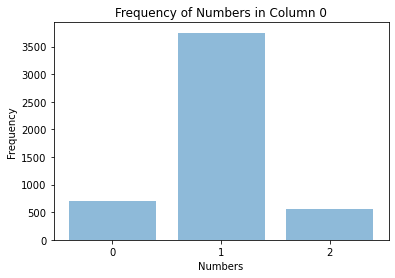

In [22]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Assuming your 2D torch tensor is named 'data'
data = prediction  # Example random data of shape (10, 5)

# Choose a specific column for analysis
column_index = 0 # Change this index to select a different column

# Get the column data as a NumPy array
column_data = data[:, column_index].numpy()

# Calculate frequency of each number
unique_numbers, counts = np.unique(column_data, return_counts=True)

# Plot the frequency
plt.bar(unique_numbers, counts, align='center', alpha=0.5)
plt.xticks(unique_numbers)
plt.xlabel('Numbers')
plt.ylabel('Frequency')
plt.title('Frequency of Numbers in Column {}'.format(column_index))
plt.show()


In [49]:
y_pred_3 = prediction.T[0]
y_pred_4 = prediction.T[1]

# Load Data

In [7]:
y_pred = np.genfromtxt("simulation/sim_ensamble_d=5000_n=[25, 25]_s=[3, 4]_fr=[5, 10]_ms=[3, 4]_id=73001/pred.csv", delimiter=",")

# Visualization

## UMAP

In [5]:
import itertools

# Replace these with your actual vectors
vector1 = y_state_3
vector2 = y_state_4

# Create a dictionary to map unique combinations to numbers
combo_to_number = {}

# Create a counter to assign unique numbers
counter = 0

combination = []

# Use itertools.product to generate unique combinations
for i in range(len(vector1)):
    combo = (vector1[i], vector2[i])
    combination.append(combo)
    if combo not in combo_to_number:
        combo_to_number[combo] = counter
        counter += 1


In [6]:
combination = list(combination)
ensemble_state = [combo_to_number[combo] for combo in combination]

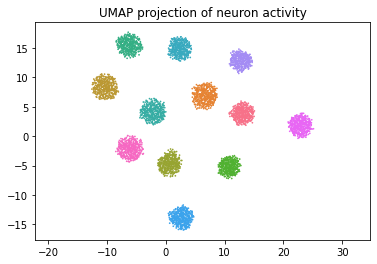

In [9]:
states = ensemble_state

X = X_state_ensamble

X_scaled = StandardScaler().fit_transform(X)

reducer = umap.UMAP(n_neighbors=10, min_dist=1)

embedding = reducer.fit_transform(X_scaled)

custom_palette = sns.color_palette("husl", len(set(states)))

plt.scatter(
    embedding[:, 0],
    embedding[:, 1], c=[custom_palette[x] for x in states], s = 0.5)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of neuron activity');

# Simulate restrictions

In [25]:
from itertools import product
from functools import reduce
import torch

def simulate_restriktions(n_state_list):
    tot_comb = reduce(lambda x, y: x * y, n_state_list)
    N = min(n_state_list)
    count = 0
    
    for prod in product(range(N+1), repeat=tot_comb):
        if not sum(prod) == tot_comb:
            continue
        tensor = torch.tensor(list(prod)).view(tuple(n_state_list))
        ok = True
        for i in range(len(n_state_list)):
            n = n_state_list[i]
            sums = torch.sum(tensor, dim = i)
            if not torch.all(sums == n):
                ok = False
        
        if ok:
            print(tensor)
            count += 1
    
    return count

n_state_list = [2,3]

simulate_restriktions(n_state_list)

tensor([[0, 1, 2],
        [2, 1, 0]])
tensor([[0, 2, 1],
        [2, 0, 1]])
tensor([[1, 0, 2],
        [1, 2, 0]])
tensor([[1, 1, 1],
        [1, 1, 1]])
tensor([[1, 2, 0],
        [1, 0, 2]])
tensor([[2, 0, 1],
        [0, 2, 1]])
tensor([[2, 1, 0],
        [0, 1, 2]])


7

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.fc = nn.Linear(10, 1)

        # Define parameters that belong to the model
        self.learning_rate = 0.01
        self.num_epochs = 10

    def forward(self, x):
        return self.fc(x)

    def fit(self, train_loader, parameters):
        criterion = nn.MSELoss()
        optimizer = optim.SGD(parameters, lr=self.learning_rate)

        for epoch in range(self.num_epochs):
            for inputs, targets in train_loader:
                optimizer.zero_grad()
                outputs = self(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()

            print(f'Epoch {epoch+1}, Loss: {loss.item()}')


In [3]:
import torch
from torch.utils.data import Dataset, DataLoader

# Define custom dataset
class CustomDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        target = self.targets[idx]
        return sample, target

# Example data
data = torch.randn(100, 10)  # Example data with 100 samples and 10 features
targets = torch.randint(0, 2, (100,))  # Example targets

# Create custom dataset instance
dataset = CustomDataset(data, targets)

# Create DataLoader
batch_size = 32
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)



In [4]:
model = MyModel()
parameters = [param for param in model.parameters()]
model.fit(train_loader, parameters)


c:\Users\eiier\anaconda3_new\envs\master\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: Found dtype Long but expected Float